In [19]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import os
import sys
import json
import warnings
warnings.filterwarnings('ignore')

from IPython.display import display
from sklearn.model_selection import GridSearchCV
sns.set_theme()
random_state = 42

In [20]:
df = pd.read_csv("kc_house_data.csv")
df['date'] = pd.to_datetime(df['date'])
df['year'] = df['date'].dt.year
df['month'] = df['date'].dt.month
df['day'] = df['date'].dt.day
df['age'] = df['year'] - df['yr_built']
df = df.drop(labels=["date","yr_built"],axis=1)

df.head(10)

,id,price,bedrooms,bathrooms,sqft_living,sqft_lot,floors,waterfront,view,condition,...,yr_renovated,zipcode,lat,long,sqft_living15,sqft_lot15,year,month,day,age
0,7129300520,221900.0,3,1.00,1180,5650,1.0,0,0,3,...,0,98178,47.5112,-122.257,1340,5650,2014,10,13,59
1,6414100192,538000.0,3,2.25,2570,7242,2.0,0,0,3,...,1991,98125,47.7210,-122.319,1690,7639,2014,12,9,63
2,5631500400,180000.0,2,1.00,770,10000,1.0,0,0,3,...,0,98028,47.7379,-122.233,2720,8062,2015,2,25,82
3,2487200875,604000.0,4,3.00,1960,5000,1.0,0,0,5,...,0,98136,47.5208,-122.393,1360,5000,2014,12,9,49
4,1954400510,510000.0,3,2.00,1680,8080,1.0,0,0,3,...,0,98074,47.6168,-122.045,1800,7503,2015,2,18,28
5,7237550310,1225000.0,4,4.50,5420,101930,1.0,0,0,3,...,0,98053,47.6561,-122.005,4760,101930,2014,5,12,13
6,1321400060,257500.0,3,2.25,1715,6819,2.0,0,0,3,...,0,98003,47.3097,-122.327,2238,6819,2014,6,27,19
7,2008000270,291850.0,3,1.50,1060,9711,1.0,0,0,3,...,0,98198,47.4095,-122.315,1650,9711,2015,1,15,52
8,2414600126,229500.0,3,1.00,1780,7470,1.0,0,0,3,...,0,98146,47.5123,-122.337,1780,8113,2015,4,15,55
9,3793500160,323000.0,3,2.50,1890,6560,2.0,0,0,3,...,0,98038,47.3684,-122.031,2390,7570,2015,3,12,12


In [21]:
from sklearn.model_selection import train_test_split

x = df.drop(labels='price',axis=1)
y = df['price']
X_train, X_test, y_train, y_test = train_test_split(x, y, test_size=0.2, random_state=42)

# Define

In [22]:
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_squared_error
from sklearn.metrics import r2_score

def evaluate(model,x_train, y_train, x_test, y_test):
    model.fit(x_train,y_train)
    
    y_test_pred = model.predict(x_test)
    y_train_pred = model.predict(x_train)
    
    Rmse = np.sqrt(mean_squared_error(y_test, y_test_pred))
    R2_score_train = r2_score(y_train, y_train_pred)
    R2_score_test = r2_score(y_test, y_test_pred)
    return Rmse, R2_score_train, R2_score_test

In [31]:
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import RobustScaler

from sklearn.feature_selection import VarianceThreshold
from sklearn.feature_selection import SelectKBest, f_classif
from sklearn.feature_selection import RFE
from sklearn.feature_selection import SequentialFeatureSelector


scaler = ['-',MinMaxScaler(), StandardScaler(), RobustScaler()]

In [32]:
def create_table(model):
    n = 45
    i = 0
    random_state = 42
    
    # RESET TABLE
    rate_table = pd.DataFrame({'Model': ['-'],
                               'Params': ['-'],
                               'FeatureSelection':['-'] ,
                               'Scaler': ['-'],
                               'Number of features': ['-'],
                               'Rmse':['-'],
                               'R2 Score(train)':['-'],
                               'R2 Score(test)':['-']})
    rate_table,i = rate_original(model,rate_table,i)
    rate_table,i = rate_variance_threshold(model,rate_table,i)
    rate_table,i = rate_SKB(model,rate_table,i)
    
    rate_table = rate_table.iloc[1:].sort_values(by='R2 Score(test)',ascending=False)
    display(rate_table)
    
    existing_df = pd.read_csv(f'exp/{model.__class__.__name__}.csv')
    merged_df = pd.concat([existing_df, rate_table], axis=0, ignore_index=True)
    merged_df.to_csv(f'exp/{model.__class__.__name__}.csv', index=False)

In [33]:
def rate_original(model,rate_table,i):
    # Original:
    Rmse, R2_score_train, R2_score_test = evaluate(model,X_train,y_train,X_test,y_test)
    num_feats = X_train.shape[1]
    row = pd.DataFrame({'Model':model.__class__.__name__,
                        'Params': str(model.get_params()),
                        'FeatureSelection': ['-'],
                        'Scaler': ['-'],
                        'Number of features': num_feats,
                        'Rmse':Rmse,
                        'R2 Score(train)':R2_score_train, 
                        'R2 Score(test)':R2_score_test})
    rate_table = pd.concat([rate_table,row],axis = 0,ignore_index=True)
    sys.stdout.write("\rProgress: [{:<22}] {:.2f}%".format("=" * (i // 2), (i / n) * 100))
    i+=1
    sys.stdout.write("\rProgress: [{:<22}] {:.2f}% \tDone original!".format("=" * (i // 2), (i / n) * 100))
    return rate_table,i

In [34]:
def rate_variance_threshold(model,rate_table,i):    
    threshold = [0.05, 0.5,1]
    for thres in threshold:
        selector = VarianceThreshold(threshold=thres)
        x_train = selector.fit_transform(X_train)
        x_test = selector.transform(X_test)
        num_feats = x_train.shape[1]
        for sc in scaler:
            if sc != '-':
                x_train = sc.fit_transform(x_train)
                x_test = sc.transform(x_test)
            Rmse, R2_score_train, R2_score_test = evaluate(model,x_train,y_train,x_test,y_test)
            row = pd.DataFrame({'Model':model.__class__.__name__,
                                'Params': str(model.get_params()),
                                'FeatureSelection': ['VarianceThreshold'],
                                'Scaler': sc,
                                'Number of features': num_feats,
                                'Rmse':Rmse,
                                'R2 Score(train)':R2_score_train, 
                                'R2 Score(test)':R2_score_test})
            rate_table = pd.concat([rate_table,row],axis = 0,ignore_index=True)
            sys.stdout.write("\rProgress: [{:<22}] {:.2f}%!".format("=" * (i // 2), (i / n) * 100))
            i+=1            
    sys.stdout.write("\rProgress: [{:<22}] {:.2f}%\tDone varThreshold!".format("=" * (i // 2), (i / n) * 100))
    return rate_table,i

In [35]:
def rate_SKB(model,rate_table,i):    
    num_bests = [19,16,12,7]
    for num in num_bests:
        selection = [(["SelectKBest"],SelectKBest(score_func = f_classif, k=num)),
                     #(["RFE"],RFE(model,n_features_to_select=num)),
                     (["SFS"],SequentialFeatureSelector(model,n_features_to_select=num,scoring='r2',cv=3))]
        for name, selector in selection:
            x_train = selector.fit_transform(X_train,y_train)
            x_test = selector.transform(X_test)
            num_feats = x_train.shape[1]
            for sc in scaler:
                if sc != '-':
                    x_train = sc.fit_transform(x_train)
                    x_test = sc.transform(x_test)
                Rmse, R2_score_train, R2_score_test = evaluate(model,x_train,y_train,x_test,y_test)
                row = pd.DataFrame({'Model':model.__class__.__name__,
                                    'Params': str(model.get_params()),
                                    'FeatureSelection': name,
                                    'Scaler': sc,
                                    'Number of features': num_feats,
                                    'Rmse':Rmse,
                                    'R2 Score(train)':R2_score_train, 
                                    'R2 Score(test)':R2_score_test})
                rate_table = pd.concat([rate_table,row],axis = 0,ignore_index=True)
                sys.stdout.write("\rProgress: [{:<22}] {:.2f}%".format("=" * (i // 2), (i / n) * 100))
                i+=1
        
        sys.stdout.write("\rProgress: [{:<22}] {:.2f}%\tDone num_feat = {}!".format("=" * (i // 2), (i / n) * 100,num))   
        
    return rate_table,i

# SVR


<img src='https://scontent-hkg4-2.xx.fbcdn.net/v/t1.15752-9/379588397_996255115024154_5614933508635326111_n.png?_nc_cat=111&ccb=1-7&_nc_sid=8cd0a2&_nc_ohc=R5m4iGfl1EkAX_Mvypy&_nc_oc=AQmNB96fYmY-lUSlK6fzmkONPdiNWytrOfnfAHU1tUqxDPHAl1kWtfJPdWeyPukyh-W92NrT32eSwjdxV_WzvHbU&_nc_ht=scontent-hkg4-2.xx&oh=03_AdRWiG576Hz0pqXF4Q9DWLGFzvTMO8WuvCrcphI-IZLWpQ&oe=6573AC9E' style="width:600px;"/>

<font size =3> &#x1F9EE; **PHƯƠNG TRÌNH HYPERPLANE:**
 
<font size = 3> $ Y = w^Tx+b$ : đường linear regression
    
<font size = 3> $ w^Tx + b ± \epsilon = 0 $: đường boundary

<font size =3> &#x1F9EE; **HÀM MẤT MÁT**:


<font size =5> $ L = \frac{1}{2}||w||^2 + C\sum_{i=1} ^n (\xi_i + \xi_i^*) \rightarrow min $<font>

<font size =5><span style="color: green; font-size: 24px;">&#10004;</span> **SỬ DỤNG THUẬT TOÁN TỐI ƯU HÓA SMO**: được thiết kế đặc biệt cho SVM và SVR

👉 **SMO sử dụng phương pháp nhân tử LAGRANGE** để tìm điểm cực tiểu có điều kiện, với điều kiện:

* $ y_i - w^Tx_i \leq \epsilon+ξ_i $
* $ w^Tx_i - y_i \leq \epsilon+ξ_i^* $
* $ ξ_i, ξ_i^* \geq 0$

💡 **HOẠT ĐỘNG**:
* Chọn 1 cặp alpha để tối ưu hóa thuộc khoảng (0,C)👇
* Giải bài toán tối ưu với điều kiển ràng buộc
* Cập nhật tham số alpha và tiếp tục giải
* Lặp lại các bước đến khi hội tụ hoặc đáp ứng điều kiện dừng

<font size =4> &#x1F9EE; **HÀM MẤT MÁT VỚI NHÂN TỬ LAGRANGE:**

<font size =5> $ L = \frac{1}{2}||w||^2 + C\sum_{i=1} ^n (\xi_i + \xi_i^*) + \sum_{i=1}^N \alpha_i(- y_i + w^T x_i - \epsilon - \xi_i)  + \sum_{i=1}^N \alpha_i^*(y_i - w^T x_i - \epsilon - \xi_i^*) - \sum_{i=1}^N \lambda_i\xi_i +\lambda_i^*\xi_i^*  $

<font size =4> &#x1F9EE; **ĐẠO HÀM THEO TỪNG BIẾN**:

sử dụng định lý **Karush - Kuhn - Tucker(KKT)**  để tìm nghiệm tối ưu của bài toán thõa mãn:

👉Theo w:  $ \frac{\partial L}{\partial w} = w - \sum_{i=1}^N (\alpha_i^*-\alpha_i)x_i $ :  = 0

=> Phép tính gần đúng của hàm: $ f(x) = Y = \sum_{i=1}^{N_SV} (\alpha_i^*-\alpha_i)x_i^Tx $
* $\alpha_i \alpha_i^*  \in  (0,C) $

👉Theo $\xi_i^*$:  $ \frac{\partial L}{\partial\xi_i^*} = C - \lambda_i^* - \alpha_i^* $ :  = 0

👉Theo $\xi_i$:  $ \frac{\partial L}{\partial\xi_i} = C - \lambda_i - \alpha_i $ :  = 0

👉Theo $\lambda_i^*$:  $ \frac{\partial L}{\partial\lambda_i^*} = \sum_{i=1}^{N}\xi_i^* $ : ≤ 0

👉Theo $\lambda_i$:  $ \frac{\partial L}{\partial\lambda_i} = \sum_{i=1}^{N}\xi_i $ : ≤ 0

👉Theo $\alpha_i$:  $ \frac{\partial L}{\partial\alpha_i} = y_i - w^Tx_i - \epsilon - \xi_i $ :  ≤0

👉Theo $\alpha_i^*$:  $ \frac{\partial L}{\partial\alpha_i^*} = y_i - w^Tx_i - \epsilon - \xi_i^* $ :  ≤0

👉 Điều kiện KKT : 
* $ \alpha(-y_i + w^Tx_i - \epsilon - \xi_i) = 0 $
* $ \alpha^*(y_i - w^Tx_i - \epsilon - \xi_i^*) = 0 $

**TÌM b:**

$ b = |y_i - w^Tx_i| - \epsilon $

# Ada Boosting Regressor

In [98]:
from sklearn.ensemble import AdaBoostRegressor
model = AdaBoostRegressor(random_state=random_state)
create_table(model)

Progress: [======================] 100.00%	Done num_feat = 7!

,Model,Params,FeatureSelection,Scaler,Number of features,Rmse,R2 Score(train),R2 Score(test)
43,AdaBoostRegressor,"{'base_estimator': None, 'learning_rate': 1.0,...",SFS,MinMaxScaler(),7,276891.403161,0.524115,0.492853
45,AdaBoostRegressor,"{'base_estimator': None, 'learning_rate': 1.0,...",SFS,RobustScaler(),7,276913.875342,0.524115,0.49277
10,AdaBoostRegressor,"{'base_estimator': None, 'learning_rate': 1.0,...",VarianceThreshold,-,13,277601.954509,0.524049,0.490247
12,AdaBoostRegressor,"{'base_estimator': None, 'learning_rate': 1.0,...",VarianceThreshold,StandardScaler(),13,277601.954509,0.524049,0.490247
34,AdaBoostRegressor,"{'base_estimator': None, 'learning_rate': 1.0,...",SFS,-,12,278348.963938,0.516906,0.487499
36,AdaBoostRegressor,"{'base_estimator': None, 'learning_rate': 1.0,...",SFS,StandardScaler(),12,282472.12175,0.497109,0.472204
37,AdaBoostRegressor,"{'base_estimator': None, 'learning_rate': 1.0,...",SFS,RobustScaler(),12,282472.12175,0.497109,0.472204
38,AdaBoostRegressor,"{'base_estimator': None, 'learning_rate': 1.0,...",SelectKBest,-,7,282773.234639,0.508103,0.471078
40,AdaBoostRegressor,"{'base_estimator': None, 'learning_rate': 1.0,...",SelectKBest,StandardScaler(),7,282773.234639,0.508103,0.471078
35,AdaBoostRegressor,"{'base_estimator': None, 'learning_rate': 1.0,...",SFS,MinMaxScaler(),12,285546.888079,0.477848,0.460651


In [28]:
model = AdaBoostRegressor(random_state=random_state)

param_grid = {
    'n_estimators': [None, 10,500],
    'learning_rate': [0.001,0.01,0.1,None]
    }
grid_search = GridSearchCV(estimator=model, param_grid=param_grid,scoring = 'r2',n_jobs=30)

grid_search.fit(X_train, y_train)

score_df = pd.DataFrame(grid_search.cv_results_)
score_df.nlargest(5,"mean_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
5,22.013229,0.056479,0.278797,0.000981,0.01,500,"{'learning_rate': 0.01, 'n_estimators': 500}",0.693325,0.700271,0.683349,0.682803,0.643673,0.680684,0.019620,1
7,0.508400,0.063367,0.008001,0.000002,0.1,10,"{'learning_rate': 0.1, 'n_estimators': 10}",0.651282,0.661235,0.650777,0.665725,0.650100,0.655824,0.006422,2
2,22.348827,0.034140,0.283599,0.006014,0.001,500,"{'learning_rate': 0.001, 'n_estimators': 500}",0.631382,0.643407,0.634449,0.652081,0.642660,0.640796,0.007301,3
4,0.479023,0.006065,0.007795,0.000398,0.01,10,"{'learning_rate': 0.01, 'n_estimators': 10}",0.562688,0.615205,0.621944,0.658817,0.622290,0.616189,0.030825,4
1,0.494200,0.042495,0.007798,0.000399,0.001,10,"{'learning_rate': 0.001, 'n_estimators': 10}",0.558084,0.598781,0.625035,0.633932,0.636222,0.610411,0.029348,5


In [36]:
#1st
from sklearn.ensemble import AdaBoostRegressor
model = AdaBoostRegressor(random_state=random_state,learning_rate=0.01,n_estimators=500)
n = 45
create_table(model)

Progress: [======================] 100.00%	Done num_feat = 7!

,Model,Params,FeatureSelection,Scaler,Number of features,Rmse,R2 Score(train),R2 Score(test)
17,AdaBoostRegressor,"{'base_estimator': None, 'learning_rate': 0.01...",SelectKBest,RobustScaler(),19,225969.979915,0.711493,0.662233
16,AdaBoostRegressor,"{'base_estimator': None, 'learning_rate': 0.01...",SelectKBest,StandardScaler(),19,226141.048442,0.711105,0.661722
15,AdaBoostRegressor,"{'base_estimator': None, 'learning_rate': 0.01...",SelectKBest,MinMaxScaler(),19,226764.354861,0.710308,0.659855
1,AdaBoostRegressor,"{'base_estimator': None, 'learning_rate': 0.01...",-,-,22,227058.200408,0.709663,0.658972
18,AdaBoostRegressor,"{'base_estimator': None, 'learning_rate': 0.01...",SFS,-,19,227230.993682,0.712732,0.658453
36,AdaBoostRegressor,"{'base_estimator': None, 'learning_rate': 0.01...",SFS,StandardScaler(),12,227647.182427,0.71078,0.657201
14,AdaBoostRegressor,"{'base_estimator': None, 'learning_rate': 0.01...",SelectKBest,-,19,227743.65462,0.710829,0.65691
42,AdaBoostRegressor,"{'base_estimator': None, 'learning_rate': 0.01...",SFS,-,7,228020.225546,0.708719,0.656077
35,AdaBoostRegressor,"{'base_estimator': None, 'learning_rate': 0.01...",SFS,MinMaxScaler(),12,228134.283533,0.709469,0.655732
43,AdaBoostRegressor,"{'base_estimator': None, 'learning_rate': 0.01...",SFS,MinMaxScaler(),7,228260.642706,0.708518,0.655351


In [39]:
#2nd
model = AdaBoostRegressor(random_state=random_state,learning_rate=0.1,n_estimators=10)
n = 45
create_table(model)

Progress: [======================] 100.00%	Done num_feat = 7!

,Model,Params,FeatureSelection,Scaler,Number of features,Rmse,R2 Score(train),R2 Score(test)
45,AdaBoostRegressor,"{'base_estimator': None, 'learning_rate': 0.1,...",SFS,RobustScaler(),7,229276.000628,0.684724,0.652278
44,AdaBoostRegressor,"{'base_estimator': None, 'learning_rate': 0.1,...",SFS,StandardScaler(),7,229276.000628,0.684724,0.652278
43,AdaBoostRegressor,"{'base_estimator': None, 'learning_rate': 0.1,...",SFS,MinMaxScaler(),7,229276.000628,0.684724,0.652278
42,AdaBoostRegressor,"{'base_estimator': None, 'learning_rate': 0.1,...",SFS,-,7,229276.000628,0.684724,0.652278
18,AdaBoostRegressor,"{'base_estimator': None, 'learning_rate': 0.1,...",SFS,-,19,234404.230803,0.684941,0.636549
37,AdaBoostRegressor,"{'base_estimator': None, 'learning_rate': 0.1,...",SFS,RobustScaler(),12,234404.230803,0.684941,0.636549
36,AdaBoostRegressor,"{'base_estimator': None, 'learning_rate': 0.1,...",SFS,StandardScaler(),12,234404.230803,0.684941,0.636549
35,AdaBoostRegressor,"{'base_estimator': None, 'learning_rate': 0.1,...",SFS,MinMaxScaler(),12,234404.230803,0.684941,0.636549
34,AdaBoostRegressor,"{'base_estimator': None, 'learning_rate': 0.1,...",SFS,-,12,234404.230803,0.684941,0.636549
29,AdaBoostRegressor,"{'base_estimator': None, 'learning_rate': 0.1,...",SFS,RobustScaler(),16,234404.230803,0.684941,0.636549


In [40]:
#3rd
model = AdaBoostRegressor(random_state=random_state,learning_rate=0.001,n_estimators=500)
n = 45
create_table(model)

Progress: [======================] 100.00%	Done num_feat = 7!

,Model,Params,FeatureSelection,Scaler,Number of features,Rmse,R2 Score(train),R2 Score(test)
14,AdaBoostRegressor,"{'base_estimator': None, 'learning_rate': 0.00...",SelectKBest,-,19,232890.171856,0.67464,0.641229
16,AdaBoostRegressor,"{'base_estimator': None, 'learning_rate': 0.00...",SelectKBest,StandardScaler(),19,233127.640834,0.67402,0.640497
44,AdaBoostRegressor,"{'base_estimator': None, 'learning_rate': 0.00...",SFS,StandardScaler(),7,233243.425086,0.676724,0.64014
17,AdaBoostRegressor,"{'base_estimator': None, 'learning_rate': 0.00...",SelectKBest,RobustScaler(),19,233246.641811,0.673828,0.64013
15,AdaBoostRegressor,"{'base_estimator': None, 'learning_rate': 0.00...",SelectKBest,MinMaxScaler(),19,233360.583128,0.673644,0.639778
45,AdaBoostRegressor,"{'base_estimator': None, 'learning_rate': 0.00...",SFS,RobustScaler(),7,233537.267342,0.675692,0.639232
1,AdaBoostRegressor,"{'base_estimator': None, 'learning_rate': 0.00...",-,-,22,233628.582207,0.673587,0.63895
43,AdaBoostRegressor,"{'base_estimator': None, 'learning_rate': 0.00...",SFS,MinMaxScaler(),7,233740.998405,0.676637,0.638603
42,AdaBoostRegressor,"{'base_estimator': None, 'learning_rate': 0.00...",SFS,-,7,233965.185371,0.675676,0.637909
28,AdaBoostRegressor,"{'base_estimator': None, 'learning_rate': 0.00...",SFS,StandardScaler(),16,234093.264726,0.675125,0.637513


In [102]:
Ada_df = pd.read_csv("exp/AdaBoostRegressor.csv")
Ada_df = Ada_df.drop_duplicates()
Ada_df.sort_values(by='R2 Score(test)',ascending=False)
Ada_df['min_samples_split'] = Ada_df['Params'].str.extract(r"'min_samples_split': (\d+)")
Ada_df['min_samples_leaf'] = Ada_df['Params'].str.extract(r"'min_samples_leaf': (\d+)")
Ada_df['overfitting'] = Ada_df['R2 Score(train)']/Ada_df['R2 Score(test)']
Ada_df = Ada_df.drop('Params', axis=1)
Ada_df.sort_values(by='R2 Score(test)',ascending=False)

,Model,FeatureSelection,Scaler,Number of features,Rmse,R2 Score(train),R2 Score(test),min_samples_split,min_samples_leaf,overfitting
45,AdaBoostRegressor,SelectKBest,RobustScaler(),19,225969.979915,0.711493,0.662233,NaN,NaN,1.074383
46,AdaBoostRegressor,SelectKBest,StandardScaler(),19,226141.048442,0.711105,0.661722,NaN,NaN,1.074629
47,AdaBoostRegressor,SelectKBest,MinMaxScaler(),19,226764.354861,0.710308,0.659855,NaN,NaN,1.076461
48,AdaBoostRegressor,-,-,22,227058.200408,0.709663,0.658972,NaN,NaN,1.076923
49,AdaBoostRegressor,SFS,-,19,227230.993682,0.712732,0.658453,NaN,NaN,1.082434
...,...,...,...,...,...,...,...,...,...,...
40,AdaBoostRegressor,SelectKBest,StandardScaler(),12,376318.665184,0.014604,0.063244,NaN,NaN,0.230910
41,AdaBoostRegressor,SelectKBest,MinMaxScaler(),12,380998.042479,-0.009436,0.039802,NaN,NaN,-0.237064
42,AdaBoostRegressor,-,-,22,390790.295594,-0.075881,-0.010189,NaN,NaN,7.447290
43,AdaBoostRegressor,SelectKBest,-,16,394534.419170,-0.091060,-0.029639,NaN,NaN,3.072337


<font size=5> **Conclusion**

<font size = 3>**Feature Selection**

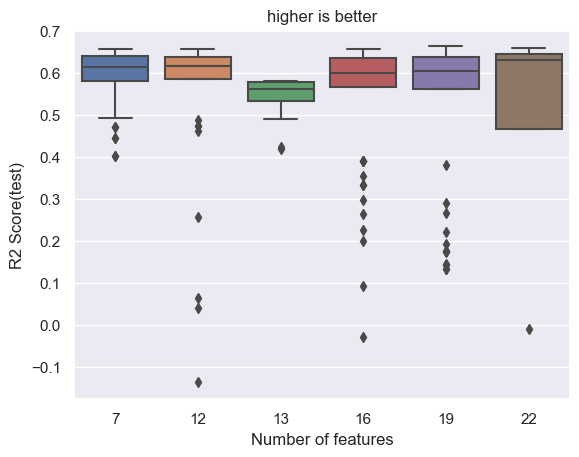

In [103]:
ax = sns.boxplot(data=Ada_df,y='R2 Score(test)',x='Number of features')
ax.set(title='higher is better');

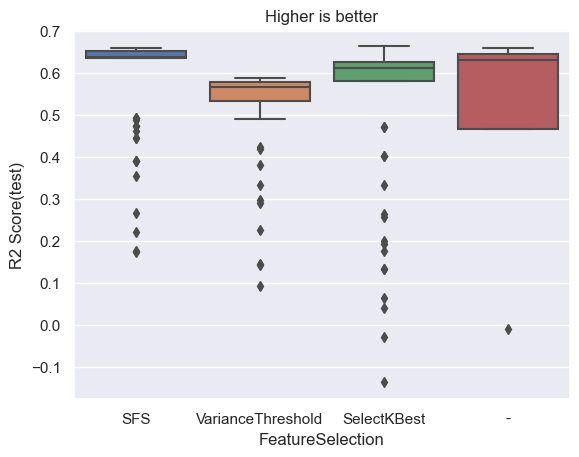

In [105]:
ax = sns.boxplot(data=Ada_df,y='R2 Score(test)',x='FeatureSelection')
ax.set(title='Higher is better',xlabel='FeatureSelection');

=> nên features selection, và ft selection bằng SFS khi áp dụng ada boost

<font size = 3>**Scale**

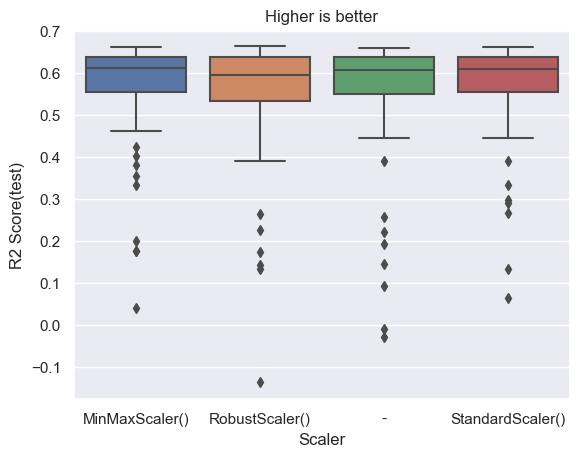

In [109]:
ax = sns.boxplot(data=Ada_df,y='R2 Score(test)',x='Scaler')
ax.set(title='Higher is better');

=> Scale không ảnh hưởng đáng kể đến hsuat mô hình

<font size = 3>**Overfitting**

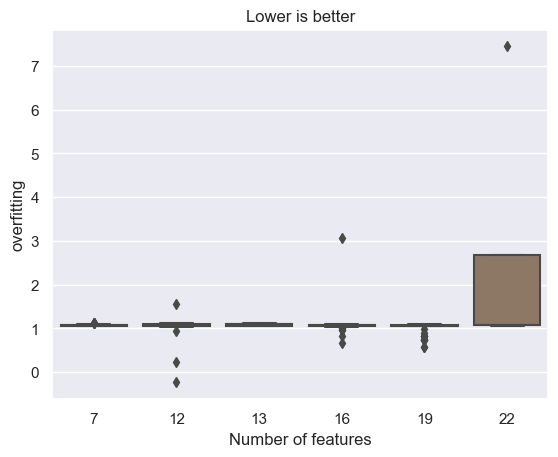

In [104]:
ax = sns.boxplot(data=Ada_df,y='overfitting',x='Number of features')
ax.set(title='Lower is better');

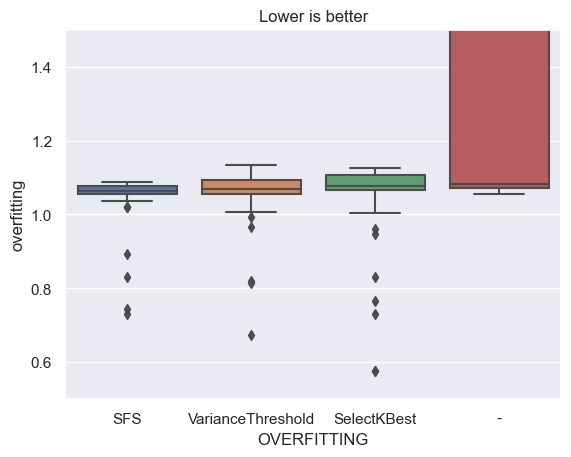

In [151]:
ax = sns.boxplot(data=Ada_df,y='overfitting',x='FeatureSelection')
ax.set(title='Lower is better',xlabel='OVERFITTING')
ax.set(ylim=[0.5,1.5]);

=> Tỉ lệ overfitting **rất thấp** khi features selection

# Gradient Boosting Regressor

👉 B1: making naive prediction on the target y:

Text(0.5, 1.0, 'Dataset ')

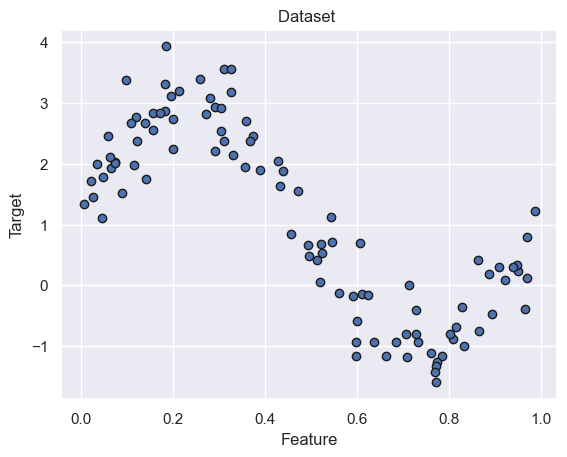

In [42]:
np.random.seed(42)
X = np.random.rand(100, 1)
y = 2 * np.sin(2 * np.pi * X) + 1 + 0.5 * np.random.randn(100, 1)
df = pd.DataFrame({'X':X.reshape(-1),'y':y.reshape(-1)})
df = df.sort_values(by='X').reset_index(drop=True)
plt.scatter(X, y, edgecolors='k')
plt.xlabel('Feature')
plt.ylabel('Target')
plt.title('Dataset ')

👉 B2: 
* Creat an "urdimentary" line  
* Focus on the residuals

In [43]:
y_mean = np.mean(y)

''

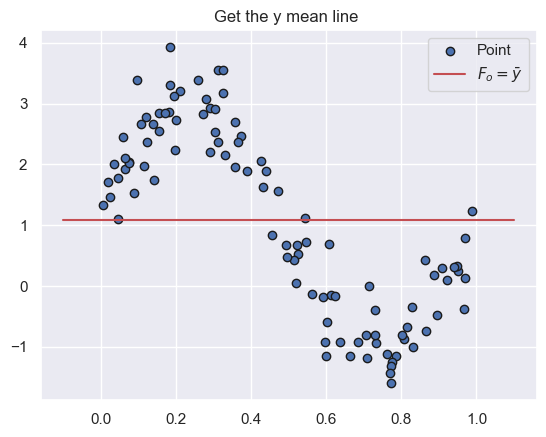

In [44]:
plt.scatter(X, y, edgecolors='k')
plt.plot([-.1,1.1],[y_mean,y_mean],color = 'r')
plt.legend(labels=['Point','$F_o = \\bar{y}$'])
plt.title('Get the y mean line ')
;

👉B3: Get the $r_1,\gamma_1$

''

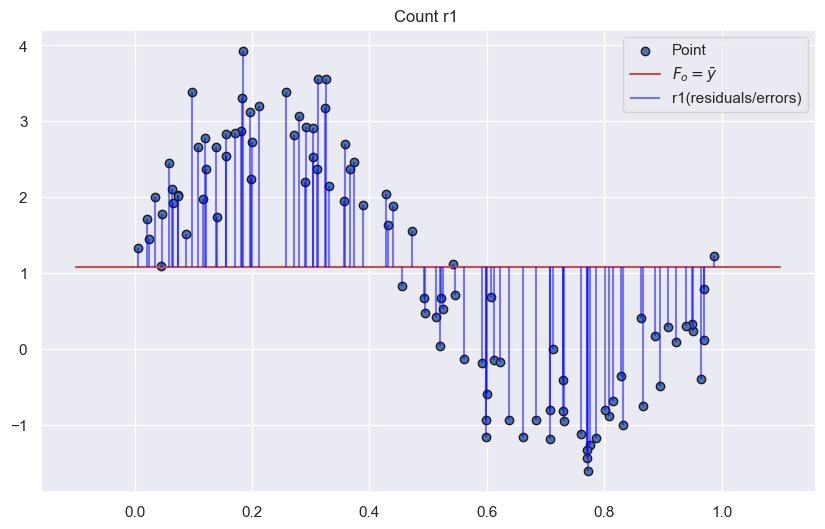

In [45]:
plt.figure(figsize=(10, 6)) 
plt.scatter(X, y, edgecolors='k')
plt.plot([-.1,1.1],[y_mean,y_mean],color = 'r')
plt.vlines(X, y_mean, y, colors='blue',alpha=0.5)
plt.legend(labels=['Point','$F_o = \\bar{y}$','r1(residuals/errors)'])
plt.title('Count r1 ')
;

In [46]:
r1 = y - y_mean

In [47]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor(max_depth=1)
model.fit(X,r1)

gamma_1_pred = model.predict(np.array(df.X).reshape(-1, 1))
gamma_1_pred


array([ 1.32172167,  1.32172167,  1.32172167,  1.32172167,  1.32172167,
        1.32172167,  1.32172167,  1.32172167,  1.32172167,  1.32172167,
        1.32172167,  1.32172167,  1.32172167,  1.32172167,  1.32172167,
        1.32172167,  1.32172167,  1.32172167,  1.32172167,  1.32172167,
        1.32172167,  1.32172167,  1.32172167,  1.32172167,  1.32172167,
        1.32172167,  1.32172167,  1.32172167,  1.32172167,  1.32172167,
        1.32172167,  1.32172167,  1.32172167,  1.32172167,  1.32172167,
        1.32172167,  1.32172167,  1.32172167,  1.32172167,  1.32172167,
        1.32172167,  1.32172167,  1.32172167,  1.32172167,  1.32172167,
        1.32172167,  1.32172167,  1.32172167,  1.32172167,  1.32172167,
        1.32172167, -1.3756695 , -1.3756695 , -1.3756695 , -1.3756695 ,
       -1.3756695 , -1.3756695 , -1.3756695 , -1.3756695 , -1.3756695 ,
       -1.3756695 , -1.3756695 , -1.3756695 , -1.3756695 , -1.3756695 ,
       -1.3756695 , -1.3756695 , -1.3756695 , -1.3756695 , -1.37

=> $\gamma_1 $= {1.32172167,-1.3756695}

In [48]:
np.unique(gamma_1_pred,return_counts=True)

(array([-1.3756695 ,  1.32172167]), array([49, 51], dtype=int64))

* x > 51 => -1.3756695
* x <=51 => 1.32172167

In [50]:
gamma_1_pred[50],gamma_1_pred[51]

(1.3217216748307388, -1.3756694982932183)

In [51]:
def F(x,index,gam1,gam2):
    gamma = np.zeros_like(x)
    for i in range(index):
        gamma[i] = gam1
    for i in range(len(x)-index):
        gamma[i+index] = gam2
    return gamma

In [52]:
gamma_1 = F(X,51,gamma_1_pred[50], gamma_1_pred[51])

''

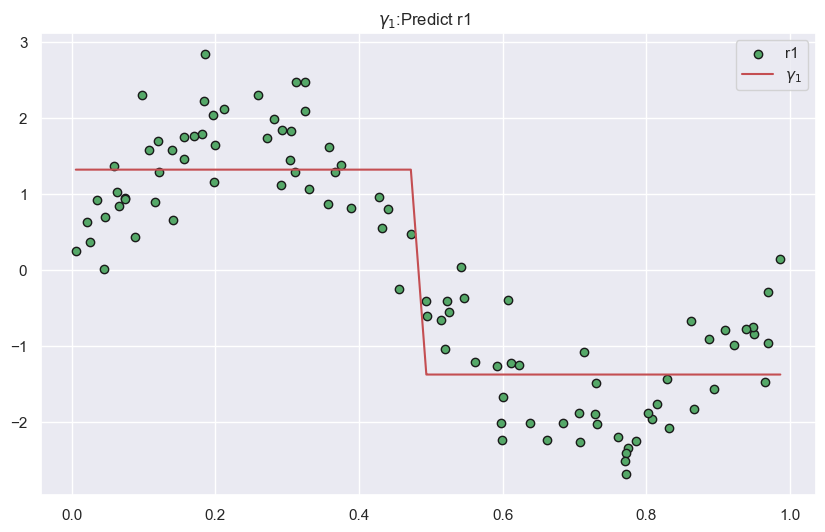

In [53]:
plt.figure(figsize=(10, 6)) 
plt.scatter(X, r1, edgecolors='k',c = 'g')
plt.plot(df.X,gamma_1.reshape(-1),color = 'r')
plt.legend(labels=['r1','$\gamma_1$'])
plt.title('$\gamma_1$:Predict r1  ')
;

In [55]:
F1 = y_mean + gamma_1

👉 Update:

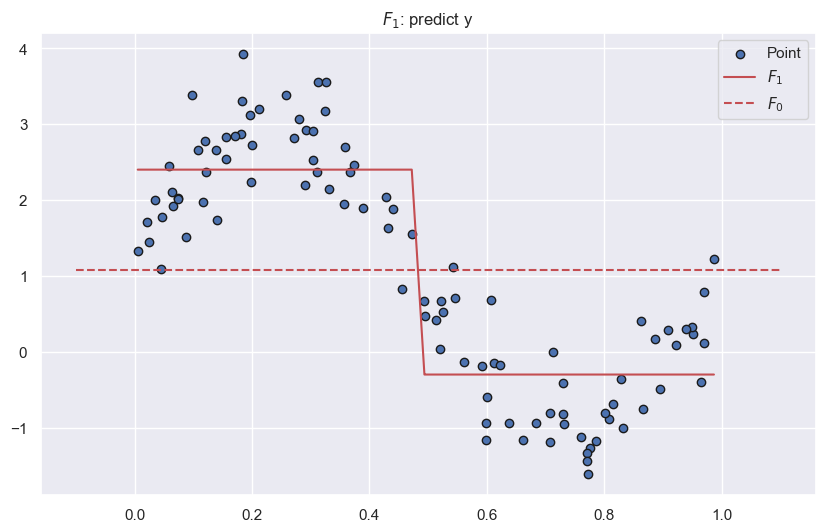

In [56]:
plt.figure(figsize=(10, 6)) 
plt.scatter(X, y, edgecolors='k')
plt.plot(df.X,F1.reshape(-1),color = 'r')
plt.plot([-.1,1.1],[y_mean,y_mean],color = 'r',ls = '--')
plt.legend(labels=['Point','$F_1$','$F_0$'])
plt.title('$F_1$: predict y ');

👉 Repeat B3:  Get $r_2,\gamma_2$

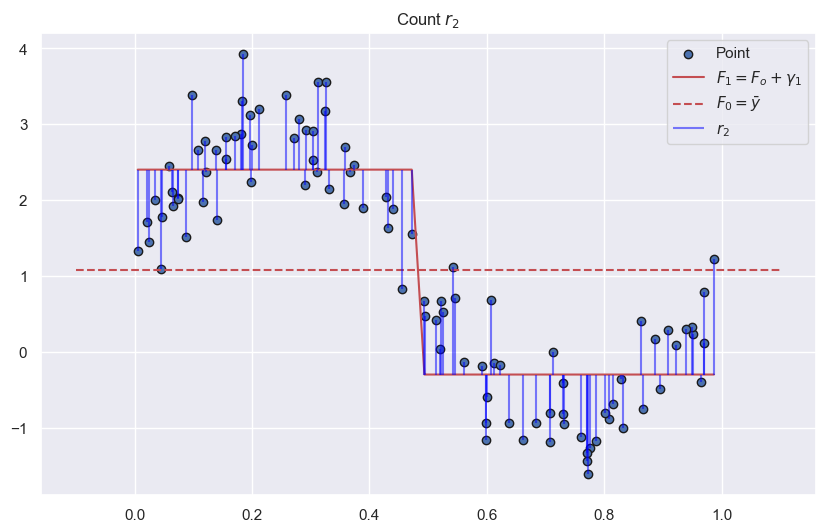

In [57]:
plt.figure(figsize=(10, 6)) 
plt.scatter(X, y, edgecolors='k')
plt.plot(df.X,F1.reshape(-1),color = 'r')
plt.plot([-.1,1.1],[y_mean,y_mean],color = 'r',ls = '--')
plt.vlines(df.X, F1.reshape(-1), df.y, colors='blue',alpha=0.5)
plt.legend(labels=['Point',
                   '$F_1 = F_o + \gamma_1 $',
                   '$F_0 = \\bar{y}$',
                   '$r_2$'])
plt.title('Count $r_2$');

In [59]:
r2 = np.array(df.y) - F1.reshape(-1)

In [60]:
from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor(max_depth=1)
model.fit(np.array(df.X).reshape(-1,1),r2)

gamma_2_pred = model.predict(np.array(df.X).reshape(-1, 1))
gamma_2_pred

array([-0.61901238, -0.61901238, -0.61901238, -0.61901238, -0.61901238,
       -0.61901238, -0.61901238, -0.61901238, -0.61901238, -0.61901238,
       -0.61901238, -0.61901238,  0.08441078,  0.08441078,  0.08441078,
        0.08441078,  0.08441078,  0.08441078,  0.08441078,  0.08441078,
        0.08441078,  0.08441078,  0.08441078,  0.08441078,  0.08441078,
        0.08441078,  0.08441078,  0.08441078,  0.08441078,  0.08441078,
        0.08441078,  0.08441078,  0.08441078,  0.08441078,  0.08441078,
        0.08441078,  0.08441078,  0.08441078,  0.08441078,  0.08441078,
        0.08441078,  0.08441078,  0.08441078,  0.08441078,  0.08441078,
        0.08441078,  0.08441078,  0.08441078,  0.08441078,  0.08441078,
        0.08441078,  0.08441078,  0.08441078,  0.08441078,  0.08441078,
        0.08441078,  0.08441078,  0.08441078,  0.08441078,  0.08441078,
        0.08441078,  0.08441078,  0.08441078,  0.08441078,  0.08441078,
        0.08441078,  0.08441078,  0.08441078,  0.08441078,  0.08

In [62]:
gamma_2 = F(X,12,gamma_2_pred[11],gamma_2_pred[12])
gamma_2_pred[11],gamma_2_pred[12]

(-0.6190123754816329, 0.08441077847476813)

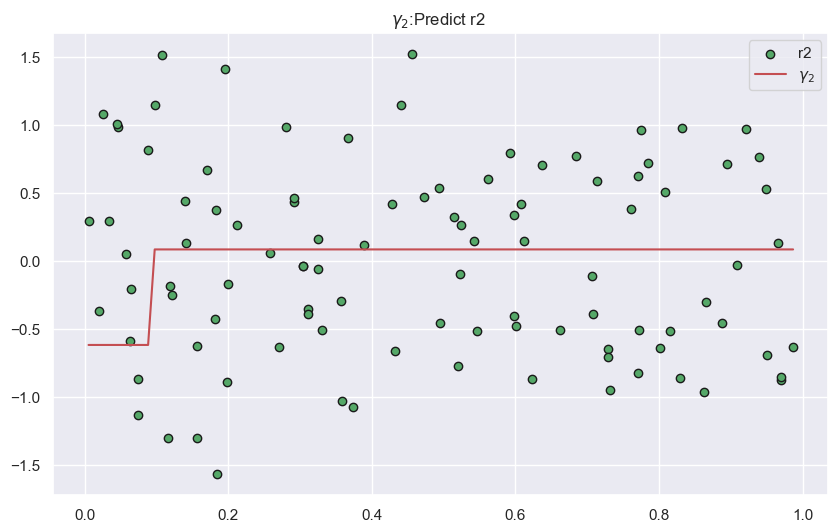

In [63]:
plt.figure(figsize=(10, 6)) 
plt.scatter(X, r2, edgecolors='k',c='g')
plt.plot(df.X,gamma_2.reshape(-1), color = 'r')

plt.legend(labels=['r2','$\gamma_2$','$y_1$'])
plt.title('$\gamma_2$:Predict r2  ');

👉 Update:

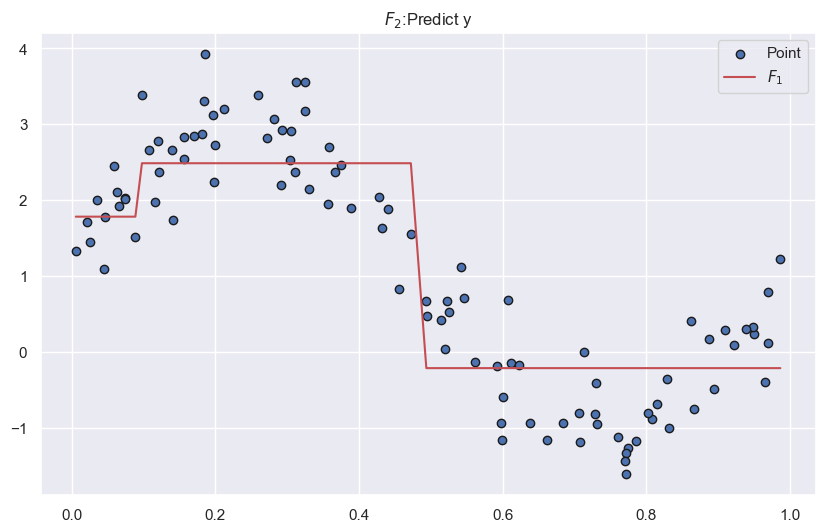

In [65]:
F2 = F1 + gamma_2


plt.figure(figsize=(10, 6)) 
plt.scatter(X, y, edgecolors='k')
plt.plot(df.X,F2.reshape(-1), color = 'r')
plt.legend(labels=['Point',
                   '$F_1$',
                   '$F_2 = F_1 + \gamma_2$'])
plt.title('$F_2$:Predict y ');

👉 Repeat B3: Get $r_3,\gamma_3$

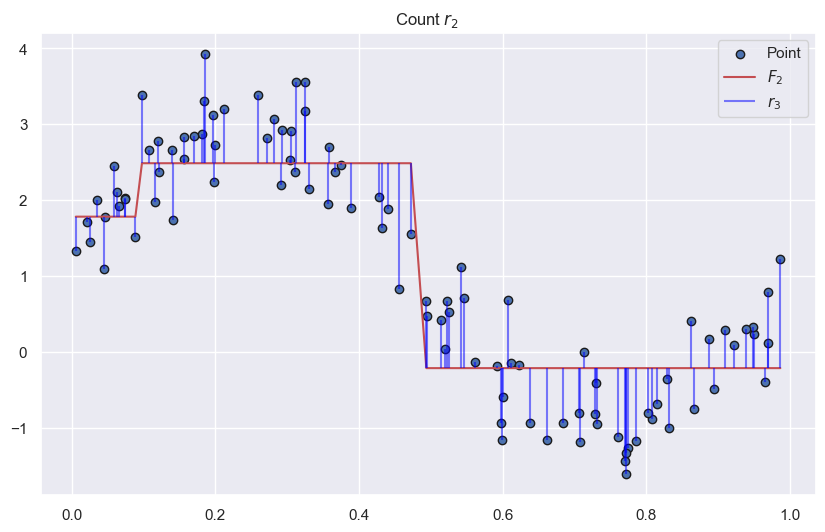

In [67]:
plt.figure(figsize=(10, 6)) 
plt.scatter(X, y, edgecolors='k')
plt.plot(df.X,F2.reshape(-1), color = 'r')

plt.vlines(df.X, F2.reshape(-1), df.y, colors='blue',alpha=0.5)


plt.legend(labels=['Point',
                   '$F_2$',
                   '$r_3$'])
plt.title('Count $r_2$ ');

In [69]:
r3 = np.array(df.y) - F2.reshape(-1)

from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor(max_depth=1)
model.fit(np.array(df.X).reshape(-1,1),r3)

gamma_3_pred = model.predict(np.array(df.X).reshape(-1, 1))
gamma_3_pred

array([ 0.17317425,  0.17317425,  0.17317425,  0.17317425,  0.17317425,
        0.17317425,  0.17317425,  0.17317425,  0.17317425,  0.17317425,
        0.17317425,  0.17317425,  0.17317425,  0.17317425,  0.17317425,
        0.17317425,  0.17317425,  0.17317425,  0.17317425,  0.17317425,
        0.17317425,  0.17317425,  0.17317425,  0.17317425,  0.17317425,
        0.17317425,  0.17317425,  0.17317425,  0.17317425,  0.17317425,
        0.17317425,  0.17317425,  0.17317425,  0.17317425,  0.17317425,
        0.17317425,  0.17317425,  0.17317425,  0.17317425,  0.17317425,
        0.17317425,  0.17317425,  0.17317425,  0.17317425,  0.17317425,
        0.17317425,  0.17317425,  0.17317425,  0.17317425,  0.17317425,
        0.17317425,  0.17317425,  0.17317425,  0.17317425,  0.17317425,
        0.17317425,  0.17317425,  0.17317425,  0.17317425,  0.17317425,
        0.17317425, -0.27086229, -0.27086229, -0.27086229, -0.27086229,
       -0.27086229, -0.27086229, -0.27086229, -0.27086229, -0.27

In [70]:
gamma_3 = F(X,61,gamma_3_pred[60],gamma_3_pred[61])
gamma_3_pred[61],gamma_3_pred[60]

(-0.270862285107373, 0.17317424785553345)

''

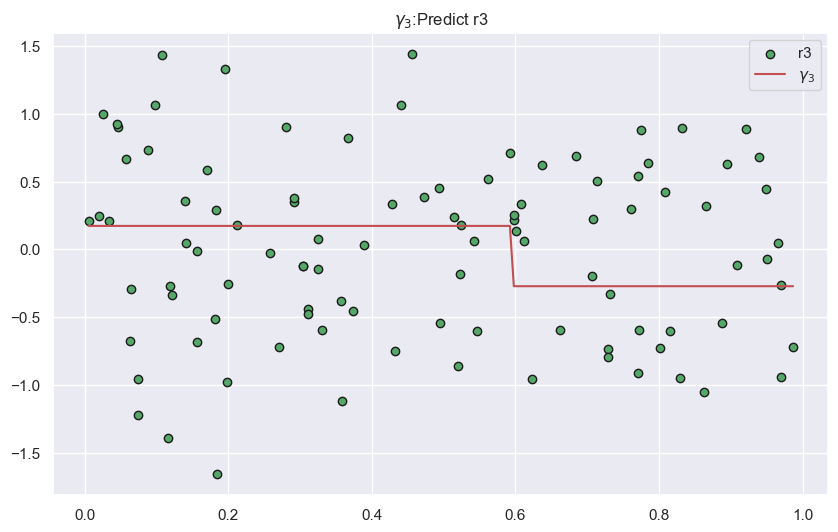

In [71]:
plt.figure(figsize=(10, 6)) 
plt.scatter(X, r3, edgecolors='k',c = 'g')
plt.plot(df.X,gamma_3.reshape(-1),color = 'r')
plt.legend(labels=['r3','$\gamma_3$'])
plt.title('$\gamma_3$:Predict r3')
;

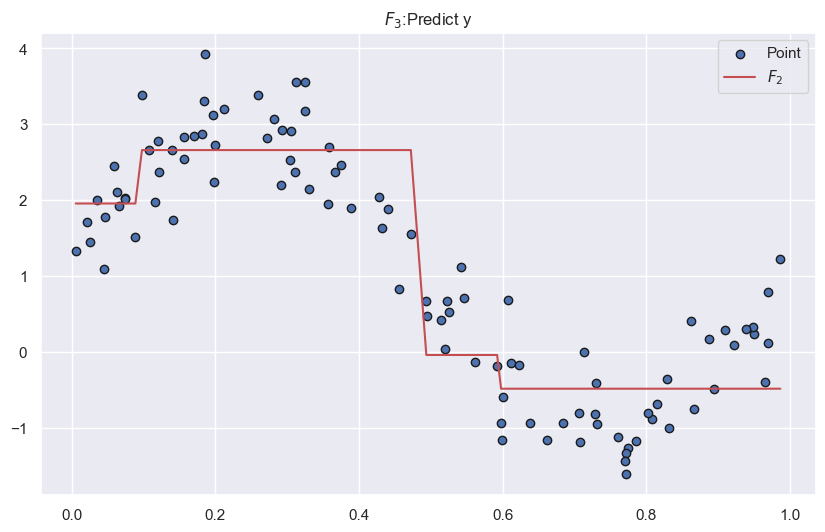

In [72]:
F3 = F2 + gamma_3


plt.figure(figsize=(10, 6)) 
plt.scatter(X, y, edgecolors='k')

plt.plot(df.X,F3.reshape(-1), color = 'r')
plt.legend(labels=['Point',
                   '$F_2$',
                   '$F_3 = F_2 + \gamma_3$'])
plt.title('$F_3$:Predict y ');

👉 Repeat B3: Get $r_4,\gamma_4$

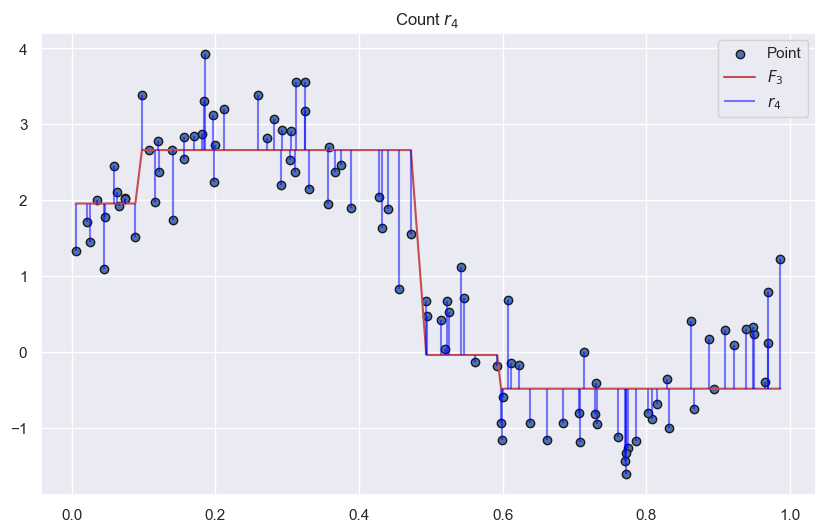

In [74]:
plt.figure(figsize=(10, 6)) 
plt.scatter(X, y, edgecolors='k')
plt.plot(df.X,F3.reshape(-1), color = 'r')

plt.vlines(df.X, F3.reshape(-1), df.y, colors='blue',alpha=0.5)


plt.legend(labels=['Point',
                   '$F_3$',
                   '$r_4$'])
plt.title('Count $r_4$ ');

In [76]:
r4 = np.array(df.y) - F3.reshape(-1)

from sklearn.tree import DecisionTreeRegressor
model = DecisionTreeRegressor(max_depth=1,random_state=random_state)
model.fit(np.array(df.X).reshape(-1,1),r4)

gamma_4_pred = model.predict(np.array(df.X).reshape(-1, 1))
gamma_4_pred

array([-0.08053115, -0.08053115, -0.08053115, -0.08053115, -0.08053115,
       -0.08053115, -0.08053115, -0.08053115, -0.08053115, -0.08053115,
       -0.08053115, -0.08053115, -0.08053115, -0.08053115, -0.08053115,
       -0.08053115, -0.08053115, -0.08053115, -0.08053115, -0.08053115,
       -0.08053115, -0.08053115, -0.08053115, -0.08053115, -0.08053115,
       -0.08053115, -0.08053115, -0.08053115, -0.08053115, -0.08053115,
       -0.08053115, -0.08053115, -0.08053115, -0.08053115, -0.08053115,
       -0.08053115, -0.08053115, -0.08053115, -0.08053115, -0.08053115,
       -0.08053115, -0.08053115, -0.08053115, -0.08053115, -0.08053115,
       -0.08053115, -0.08053115, -0.08053115, -0.08053115, -0.08053115,
       -0.08053115, -0.08053115, -0.08053115, -0.08053115, -0.08053115,
       -0.08053115, -0.08053115, -0.08053115, -0.08053115, -0.08053115,
       -0.08053115, -0.08053115, -0.08053115, -0.08053115, -0.08053115,
       -0.08053115, -0.08053115, -0.08053115, -0.08053115, -0.08

In [77]:
gamma_4 = F(X,91,gamma_4_pred[90],gamma_4_pred[91])
gamma_4_pred[90],gamma_4_pred[91]

(-0.08053115217411981, 0.8142594275383233)

''

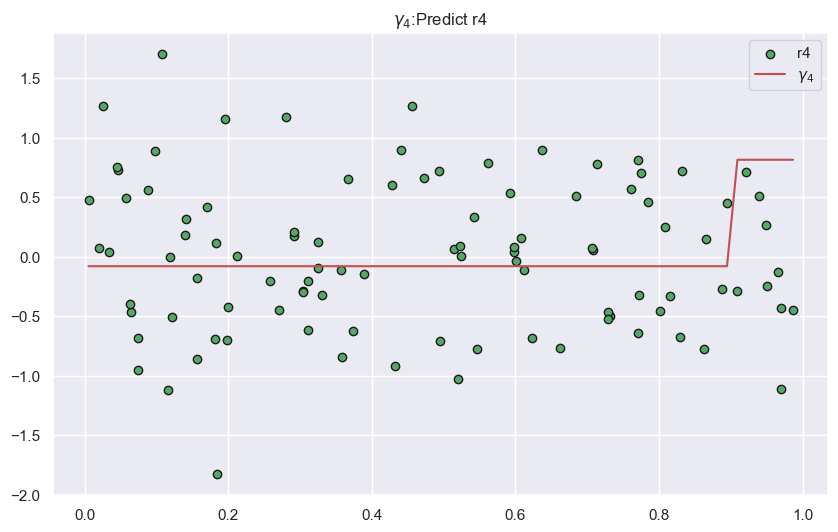

In [80]:
plt.figure(figsize=(10, 6)) 
plt.scatter(X, r4, edgecolors='k',c = 'g')
plt.plot(df.X,gamma_4.reshape(-1),color = 'r')
plt.legend(labels=['r4','$\gamma_4$'])
plt.title('$\gamma_4$:Predict r4')
;

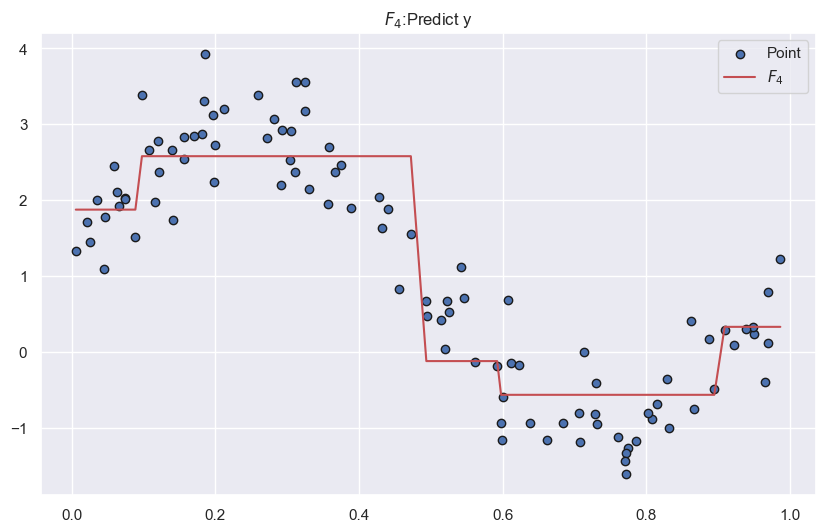

In [81]:
F4 = F3 + gamma_4

plt.figure(figsize=(10, 6)) 
plt.scatter(X, y, edgecolors='k')
plt.plot(df.X,F4.reshape(-1), color = 'r')
plt.legend(labels=['Point',
                   '$F_4$'])
plt.title('$F_4$:Predict y ');

In [97]:
print('RMSE:' ,np.sqrt(mean_squared_error(np.array(df.y), F4)),
      '\nR2 score:',r2_score(np.array(df.y),F4))

RMSE: 0.5756819041081709 
R2 score: 0.8568049223984736


<font size = 5> **🔍 Compare to sk learn**

In [100]:
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor(n_estimators=4, learning_rate=1, max_depth=1, random_state=42)
gb_model.fit(np.array(df.X).reshape(-1,1),np.array(df.y).reshape(-1,1))
y_predict = gb_model.predict(np.array(df.X).reshape(-1,1))

print('RMSE:' ,np.sqrt(mean_squared_error(np.array(df.y), y_predict)),
      '\nR2 score:',r2_score(np.array(df.y),y_predict))

RMSE: 0.5756819041081709 
R2 score: 0.8568049223984736


<font size = 5> **Apply House data**

In [114]:
model = GradientBoostingRegressor(n_estimators=10, learning_rate=0.5, max_depth=1, random_state=random_state)
create_table(model)

Progress: [======================] 100.00%	Done num_feat = 7!

,Model,Params,FeatureSelection,Scaler,Number of features,Rmse,R2 Score(train),R2 Score(test)
45,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SFS,RobustScaler(),7,225525.421313,0.673543,0.663561
44,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SFS,StandardScaler(),7,225525.421313,0.673543,0.663561
43,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SFS,MinMaxScaler(),7,225525.421313,0.673543,0.663561
42,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SFS,-,7,225525.421313,0.673543,0.663561
33,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SelectKBest,RobustScaler(),12,225525.421313,0.673543,0.663561
32,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SelectKBest,StandardScaler(),12,225525.421313,0.673543,0.663561
31,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SelectKBest,MinMaxScaler(),12,225525.421313,0.673543,0.663561
30,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SelectKBest,-,12,225525.421313,0.673543,0.663561
14,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SelectKBest,-,19,225525.421313,0.673543,0.663561
17,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SelectKBest,RobustScaler(),19,225525.421313,0.673543,0.663561


In [115]:
model = GradientBoostingRegressor(n_estimators=10, learning_rate=0.01, max_depth=1, random_state=random_state)
create_table(model)

Progress: [======================] 100.00%	Done num_feat = 7!

,Model,Params,FeatureSelection,Scaler,Number of features,Rmse,R2 Score(train),R2 Score(test)
1,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",-,-,22,378041.879404,0.059177,0.054645
33,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SelectKBest,RobustScaler(),12,378041.879404,0.059177,0.054645
32,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SelectKBest,StandardScaler(),12,378041.879404,0.059177,0.054645
31,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SelectKBest,MinMaxScaler(),12,378041.879404,0.059177,0.054645
30,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SelectKBest,-,12,378041.879404,0.059177,0.054645
25,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SelectKBest,RobustScaler(),16,378041.879404,0.059177,0.054645
22,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SelectKBest,-,16,378041.879404,0.059177,0.054645
41,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SelectKBest,RobustScaler(),7,378041.879404,0.059177,0.054645
40,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SelectKBest,StandardScaler(),7,378041.879404,0.059177,0.054645
39,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SelectKBest,MinMaxScaler(),7,378041.879404,0.059177,0.054645


In [116]:
model = GradientBoostingRegressor(n_estimators=10, learning_rate=0.9, max_depth=1, random_state=random_state)
create_table(model)

Progress: [======================] 100.00%	Done num_feat = 7!

,Model,Params,FeatureSelection,Scaler,Number of features,Rmse,R2 Score(train),R2 Score(test)
38,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SelectKBest,-,7,228773.096958,0.678271,0.653802
41,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SelectKBest,RobustScaler(),7,228773.096958,0.678271,0.653802
40,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SelectKBest,StandardScaler(),7,228773.096958,0.678271,0.653802
39,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SelectKBest,MinMaxScaler(),7,228773.096958,0.678271,0.653802
34,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SFS,-,12,230225.112659,0.681214,0.649393
35,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SFS,MinMaxScaler(),12,230225.112659,0.681214,0.649393
37,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SFS,RobustScaler(),12,230225.112659,0.681214,0.649393
1,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",-,-,22,230225.112659,0.681214,0.649393
36,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SFS,StandardScaler(),12,230225.112659,0.681214,0.649393
27,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SFS,MinMaxScaler(),16,230225.112659,0.681214,0.649393


In [123]:
model = GradientBoostingRegressor(random_state=random_state)

param_grid = {
    'n_estimators': [5,20,100],
    'learning_rate': [0.01,0.1,0.5],
    'max_depth' : [1,2,5]
    }
grid_search = GridSearchCV(estimator=model, param_grid=param_grid,scoring = 'r2',n_jobs=20)

grid_search.fit(X_train, y_train)

score_df = pd.DataFrame(grid_search.cv_results_)
score_df.nlargest(10,"mean_test_score")

,mean_fit_time,std_fit_time,mean_score_time,std_score_time,param_learning_rate,param_max_depth,param_n_estimators,params,split0_test_score,split1_test_score,split2_test_score,split3_test_score,split4_test_score,mean_test_score,std_test_score,rank_test_score
17,6.133449,0.015525,0.012391,4.981332e-04,0.1,5,100,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.898826,0.895914,0.900186,0.892696,0.876561,0.892837,0.008536,1
26,5.986047,0.128290,0.010200,4.004012e-04,0.5,5,100,"{'learning_rate': 0.5, 'max_depth': 5, 'n_esti...",0.876120,0.885179,0.865198,0.870692,0.857329,0.870904,0.009464,2
25,1.238600,0.004499,0.004801,4.002828e-04,0.5,5,20,"{'learning_rate': 0.5, 'max_depth': 5, 'n_esti...",0.871121,0.877376,0.860428,0.866241,0.851663,0.865366,0.008835,3
23,2.512800,0.005706,0.006201,4.007352e-04,0.5,2,100,"{'learning_rate': 0.5, 'max_depth': 2, 'n_esti...",0.868384,0.862241,0.871897,0.852454,0.850334,0.861062,0.008504,4
14,2.527400,0.006621,0.006600,4.897068e-04,0.1,2,100,"{'learning_rate': 0.1, 'max_depth': 2, 'n_esti...",0.840164,0.849100,0.842606,0.837101,0.822891,0.838372,0.008689,5
24,0.314200,0.000748,0.003400,4.897651e-04,0.5,5,5,"{'learning_rate': 0.5, 'max_depth': 5, 'n_esti...",0.830871,0.851120,0.830931,0.841608,0.814996,0.833905,0.012094,6
16,1.232800,0.002482,0.005600,4.898819e-04,0.1,5,20,"{'learning_rate': 0.1, 'max_depth': 5, 'n_esti...",0.820859,0.831757,0.828705,0.833744,0.805801,0.824173,0.010180,7
22,0.513000,0.001095,0.003801,4.001625e-04,0.5,2,20,"{'learning_rate': 0.5, 'max_depth': 2, 'n_esti...",0.807074,0.815376,0.823482,0.799896,0.798136,0.808793,0.009537,8
20,1.305600,0.002871,0.004999,1.378711e-06,0.5,1,100,"{'learning_rate': 0.5, 'max_depth': 1, 'n_esti...",0.802285,0.807381,0.803254,0.789466,0.775757,0.795629,0.011606,9
11,1.308800,0.004214,0.005000,2.431402e-07,0.1,1,100,"{'learning_rate': 0.1, 'max_depth': 1, 'n_esti...",0.731710,0.741101,0.740537,0.750130,0.725091,0.737714,0.008591,10


In [118]:
#1st
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=5, random_state=random_state)
create_table(model)

Progress: [======================] 100.00%	Done num_feat = 7!

,Model,Params,FeatureSelection,Scaler,Number of features,Rmse,R2 Score(train),R2 Score(test)
26,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SFS,-,16,134525.234858,0.940988,0.880292
27,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SFS,MinMaxScaler(),16,135018.10392,0.94217,0.879413
29,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SFS,RobustScaler(),16,135280.774339,0.94217,0.878944
28,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SFS,StandardScaler(),16,135345.308013,0.942177,0.878828
35,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SFS,MinMaxScaler(),12,136709.602377,0.939681,0.876373
34,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SFS,-,12,136848.88092,0.939681,0.876121
37,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SFS,RobustScaler(),12,136870.914024,0.939681,0.876081
36,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SFS,StandardScaler(),12,137068.040458,0.939681,0.875724
20,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SFS,StandardScaler(),19,139701.898263,0.946089,0.870902
21,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SFS,RobustScaler(),19,140123.20687,0.945557,0.870122


In [119]:
#2nd
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.5, max_depth=5, random_state=random_state)
create_table(model)

Progress: [======================] 100.00%	Done num_feat = 7!

,Model,Params,FeatureSelection,Scaler,Number of features,Rmse,R2 Score(train),R2 Score(test)
3,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",VarianceThreshold,MinMaxScaler(),19,153996.899584,0.967657,0.84313
23,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SelectKBest,MinMaxScaler(),16,154773.78927,0.969257,0.841544
25,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SelectKBest,RobustScaler(),16,155123.436707,0.968835,0.840827
4,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",VarianceThreshold,StandardScaler(),19,155836.715727,0.968442,0.83936
42,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SFS,-,7,156160.58157,0.958945,0.838691
45,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SFS,RobustScaler(),7,156227.404273,0.958945,0.838553
43,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SFS,MinMaxScaler(),7,156284.907904,0.958945,0.838434
24,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SelectKBest,StandardScaler(),16,156388.821527,0.9694,0.838219
29,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SFS,RobustScaler(),16,156464.937891,0.968804,0.838062
44,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SFS,StandardScaler(),7,156565.969238,0.958945,0.837853


In [120]:
#3rd
model = GradientBoostingRegressor(n_estimators=20, learning_rate=0.5, max_depth=5, random_state=random_state)
create_table(model)

Progress: [======================] 100.00%	Done num_feat = 7!

,Model,Params,FeatureSelection,Scaler,Number of features,Rmse,R2 Score(train),R2 Score(test)
34,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SFS,-,12,149865.452917,0.931846,0.851434
36,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SFS,StandardScaler(),12,149867.918299,0.931846,0.85143
35,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SFS,MinMaxScaler(),12,149868.685886,0.931846,0.851428
37,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SFS,RobustScaler(),12,149873.391953,0.931846,0.851419
29,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SFS,RobustScaler(),16,153108.085938,0.932167,0.844936
26,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SFS,-,16,153280.623688,0.932167,0.844586
28,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SFS,StandardScaler(),16,153416.624249,0.932167,0.84431
27,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SFS,MinMaxScaler(),16,153428.309091,0.932167,0.844287
20,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SFS,StandardScaler(),19,156852.206301,0.933032,0.837259
21,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SFS,RobustScaler(),19,157187.903617,0.933032,0.836562


In [121]:
#4th
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.5, max_depth=2, random_state=random_state)
create_table(model)

Progress: [======================] 100.00%	Done num_feat = 7!

,Model,Params,FeatureSelection,Scaler,Number of features,Rmse,R2 Score(train),R2 Score(test)
1,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",-,-,22,152186.652306,0.908985,0.846797
14,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SelectKBest,-,19,153377.991423,0.907044,0.844389
16,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SelectKBest,StandardScaler(),19,153539.010098,0.907626,0.844062
15,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SelectKBest,MinMaxScaler(),19,153539.010098,0.907626,0.844062
17,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SelectKBest,RobustScaler(),19,153647.741243,0.907626,0.843841
44,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SFS,StandardScaler(),7,154741.87803,0.887772,0.841609
43,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SFS,MinMaxScaler(),7,154741.87803,0.887772,0.841609
42,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SFS,-,7,154741.87803,0.887772,0.841609
45,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SFS,RobustScaler(),7,154788.922047,0.887772,0.841513
28,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SFS,StandardScaler(),16,156085.794583,0.902774,0.838846


In [122]:
#5th
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=2, random_state=random_state)
create_table(model)

Progress: [======================] 100.00%	Done num_feat = 7!

,Model,Params,FeatureSelection,Scaler,Number of features,Rmse,R2 Score(train),R2 Score(test)
1,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",-,-,22,170925.012582,0.862277,0.806747
26,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SFS,-,16,171365.760138,0.861564,0.805749
27,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SFS,MinMaxScaler(),16,171365.760138,0.861564,0.805749
29,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SFS,RobustScaler(),16,171415.048543,0.861564,0.805637
28,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SFS,StandardScaler(),16,171415.048543,0.861564,0.805637
43,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SFS,MinMaxScaler(),7,172096.708282,0.844939,0.804088
42,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SFS,-,7,172096.708282,0.844939,0.804088
44,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SFS,StandardScaler(),7,172140.811905,0.844939,0.803988
45,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SFS,RobustScaler(),7,172140.811905,0.844939,0.803988
15,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SelectKBest,MinMaxScaler(),19,172209.304579,0.862287,0.803832


In [124]:
model = GradientBoostingRegressor(n_estimators=100, learning_rate=0.1, max_depth=1, random_state=random_state)
create_table(model)

Progress: [======================] 100.00%	Done num_feat = 7!

,Model,Params,FeatureSelection,Scaler,Number of features,Rmse,R2 Score(train),R2 Score(test)
37,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SFS,RobustScaler(),12,208775.331023,0.755064,0.711681
36,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SFS,StandardScaler(),12,208775.331023,0.755064,0.711681
35,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SFS,MinMaxScaler(),12,208775.331023,0.755064,0.711681
34,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SFS,-,12,208775.331023,0.755064,0.711681
1,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",-,-,22,208844.953752,0.75517,0.711489
14,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SelectKBest,-,19,208844.953752,0.75517,0.711489
26,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SFS,-,16,208844.953752,0.75517,0.711489
21,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SFS,RobustScaler(),19,208844.953752,0.75517,0.711489
20,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SFS,StandardScaler(),19,208844.953752,0.75517,0.711489
18,GradientBoostingRegressor,"{'alpha': 0.9, 'ccp_alpha': 0.0, 'criterion': ...",SFS,-,19,208844.953752,0.75517,0.711489


In [136]:
GB_df = pd.read_csv("exp/GradientBoostingRegressor.csv")
GB_df = GB_df.drop_duplicates()
GB_df.sort_values(by='R2 Score(test)',ascending=False)
GB_df['learning_rate'] = GB_df['Params'].str.extract(r"'learning_rate': (\d+.\d+)")
GB_df['number of trees'] = GB_df['Params'].str.extract(r"'n_estimators': (\d+)")
GB_df['max_depth'] = GB_df['Params'].str.extract(r"'max_depth': (\d+)")
GB_df['overfitting'] = GB_df['R2 Score(train)']/GB_df['R2 Score(test)']
GB_df = GB_df.drop('Params', axis=1)
GB_df.sort_values(by='R2 Score(test)',ascending=False)

,Model,FeatureSelection,Scaler,Number of features,Rmse,R2 Score(train),R2 Score(test),learning_rate,number of trees,max_depth,overfitting
135,GradientBoostingRegressor,SFS,-,16,134525.234858,0.940988,0.880292,0.1,100,5,1.068950
136,GradientBoostingRegressor,SFS,MinMaxScaler(),16,135018.103920,0.942170,0.879413,0.1,100,5,1.071362
137,GradientBoostingRegressor,SFS,RobustScaler(),16,135280.774339,0.942170,0.878944,0.1,100,5,1.071935
138,GradientBoostingRegressor,SFS,StandardScaler(),16,135345.308013,0.942177,0.878828,0.1,100,5,1.072083
139,GradientBoostingRegressor,SFS,MinMaxScaler(),12,136709.602377,0.939681,0.876373,0.1,100,5,1.072238
...,...,...,...,...,...,...,...,...,...,...,...
82,GradientBoostingRegressor,SFS,-,12,378049.761800,0.059029,0.054606,0.01,10,1,1.081013
86,GradientBoostingRegressor,SFS,StandardScaler(),16,378049.761800,0.059029,0.054606,0.01,10,1,1.081013
88,GradientBoostingRegressor,SFS,MinMaxScaler(),16,378049.761800,0.059029,0.054606,0.01,10,1,1.081013
89,GradientBoostingRegressor,SFS,-,16,378049.761800,0.059029,0.054606,0.01,10,1,1.081013


<font size = 5> **Conclusion**

<font size = 3> **Feature selection**

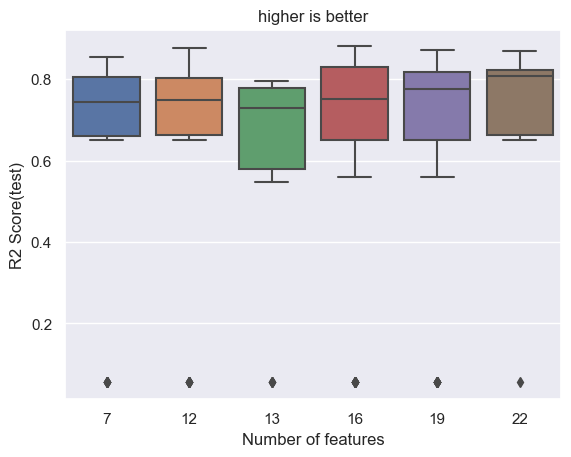

In [137]:
ax = sns.boxplot(data=GB_df,y='R2 Score(test)',x='Number of features')
ax.set(title='higher is better');

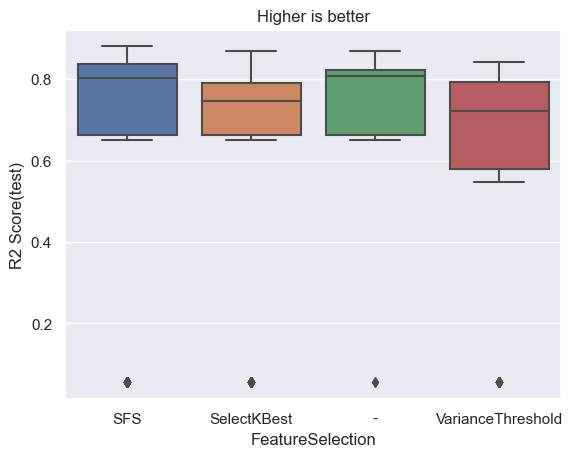

In [138]:
ax = sns.boxplot(data=GB_df,y='R2 Score(test)',x='FeatureSelection')
ax.set(title='Higher is better',xlabel='FeatureSelection');

<span style="color: green; font-size: 24px;">&#10004;</span> Không áp dụng feature selection thì cho hiệu suất tốt nhất

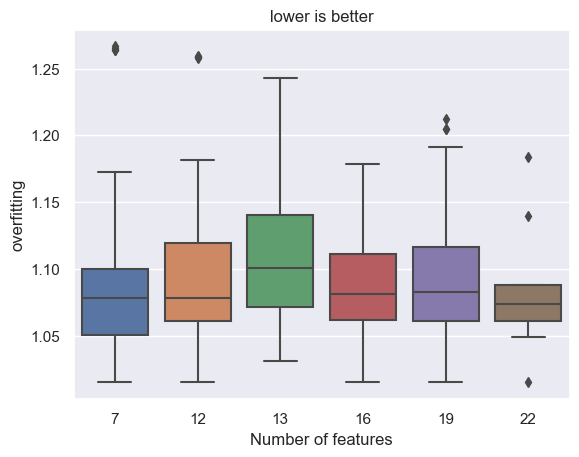

In [139]:
ax = sns.boxplot(data=GB_df,y='overfitting',x='Number of features')
ax.set(title='lower is better');

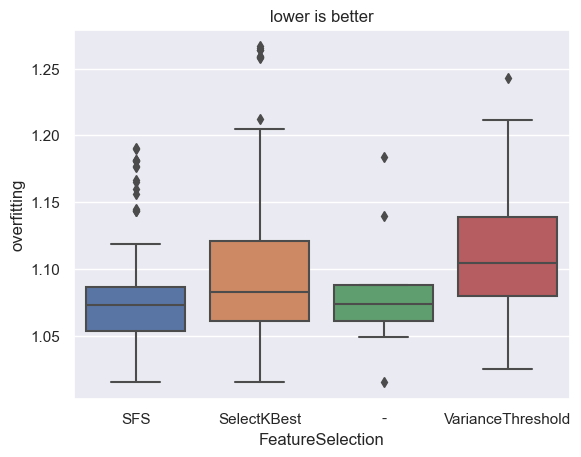

In [140]:
ax = sns.boxplot(data=GB_df,y='overfitting',x='FeatureSelection')
ax.set(title='lower is better',xlabel='FeatureSelection');

<span style="color: green; font-size: 24px;">&#10004;</span> Tương tự, không ft selection thì tỉ lệ overfitting thấp nhất

<font size = 3> **Number of trees**

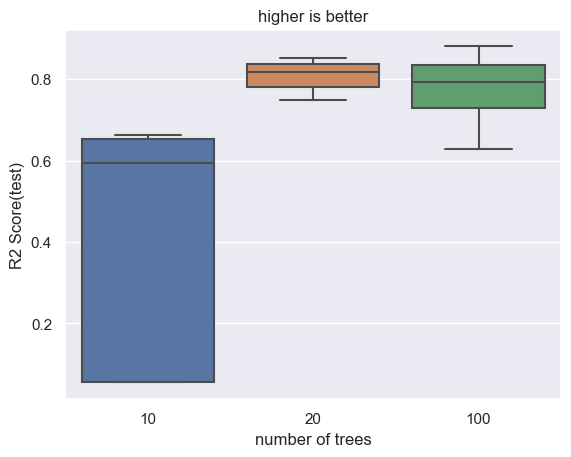

In [142]:
ax = sns.boxplot(data=GB_df,y='R2 Score(test)',x='number of trees',order=['10','20','100'])
ax.set(title='higher is better');

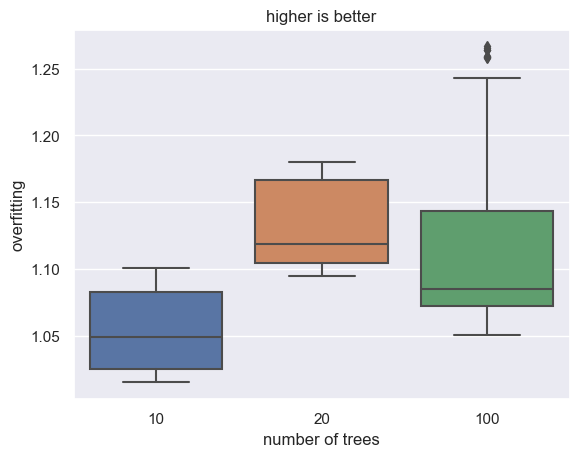

In [143]:
ax = sns.boxplot(data=GB_df,y='overfitting',x='number of trees',order=['10','20','100'])
ax.set(title='higher is better');

👉 Càng nhiều cây thì hiệu suất càng cao nhưng tỉ lệ overfitting cũng càng nhiều hơn

<font size = 3> **learning_rate**

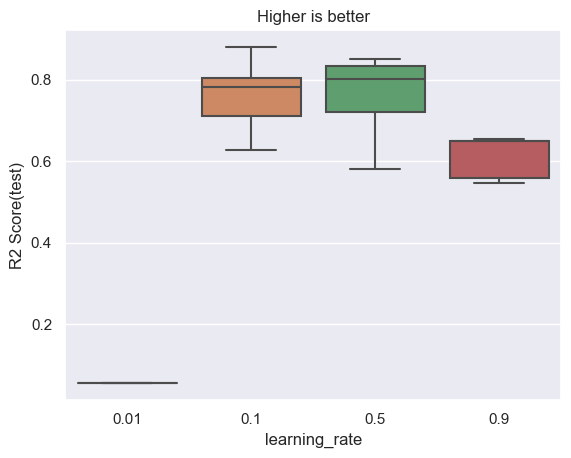

In [147]:
ax = sns.boxplot(data=GB_df,y='R2 Score(test)',x='learning_rate',order = ['0.01','0.1','0.5','0.9'])
ax.set(title='Higher is better',xlabel='learning_rate');

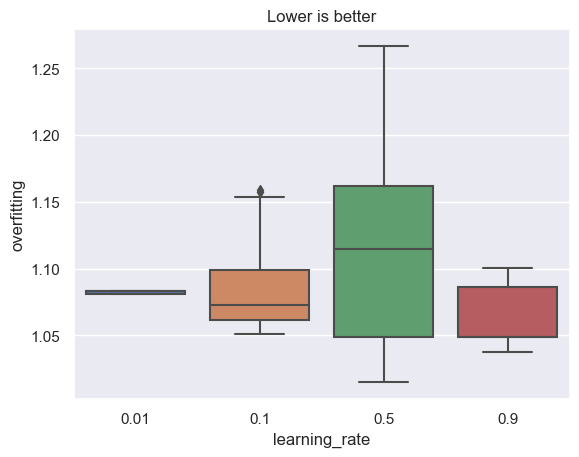

In [148]:
ax = sns.boxplot(data=GB_df,y='overfitting',x='learning_rate',order = ['0.01','0.1','0.5','0.9'])
ax.set(title='Lower is better',xlabel='learning_rate');

👉 Learning rate quá thấp => không học được gì

👉 Ngược lại thì hiệu suất của mô hình thấp

<span style="color: green; font-size: 24px;">&#10004;</span> Best => 0.1

<font size=3> **Max depth**

In [ ]:
max_depth

[Text(0.5, 1.0, 'Higher is better'), Text(0.5, 0, 'Max depth')]

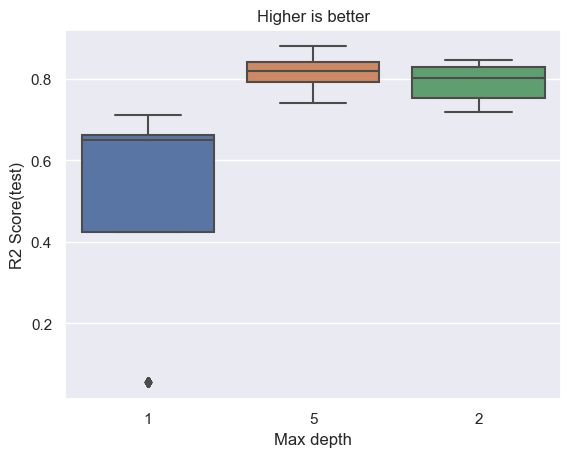

In [149]:
ax = sns.boxplot(data=GB_df,y='R2 Score(test)',x='max_depth')
ax.set(title='Higher is better',xlabel='Max depth')

[Text(0.5, 1.0, 'Lower is better'), Text(0.5, 0, 'overfitting')]

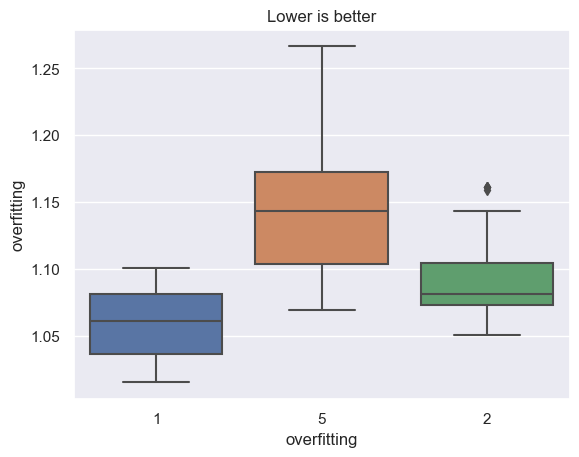

In [150]:
ax = sns.boxplot(data=GB_df,y='overfitting',x='max_depth')
ax.set(title='Lower is better',xlabel='overfitting')

👉 Cây càng sâu => overfitting càng cao, nhưng hiệu suất cũng tăng

👉Max depth = 2: Hiệu suất cao, overfitting khá thấp

# EMOJI

<span style="color:red">&#10060;</span> : X

👉 👇


⚠️

<span style="color: green; font-size: 24px;">&#10004;</span> : Dấu tích

&#128161; : bóng đèn

<font size =5> &#x1F9EE; Công thức 

<font size =5> &#x1F4DA; : Bài tập
   
<img src='link' style="width:500px;"/> : Chèn ảnh
    
<div style="margin-left: 200px;">: căn lề